In [1]:
!git clone https://github.com/mseaberg/lcls_beamline_toolbox
import os
os.chdir('lcls_beamline_toolbox')
!python3 -m pip install -e .
!pip install xraydb -q
!pip install botorch -q
!pip install xopt -q

Cloning into 'lcls_beamline_toolbox'...
remote: Enumerating objects: 3287, done.
remote: Counting objects: 100% (558/558), done.
remote: Compressing objects: 100% (193/193), done.
remote: Total 3287 (delta 487), reused 427 (delta 365), pack-reused 2729
Receiving objects: 100% (3287/3287), 232.16 MiB | 10.37 MiB/s, done.
Resolving deltas: 100% (2537/2537), done.
Updating files: 100% (144/144), done.
Obtaining file:///content/lcls_beamline_toolbox
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 11.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.4/123.4 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.1/121.1 kB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.5/93.5 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 35.7 MB/s eta 0:00:00
  Created wheel for xrt: filename=xrt-1.6.0-py3-none-any.whl 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lcls_beamline_toolbox.xraywavetrace.beam1d as beam
import lcls_beamline_toolbox.xraywavetrace.optics1d as optics
import lcls_beamline_toolbox.xraywavetrace.beamline1d as beamline
import scipy.optimize as optimize
import copy
import scipy.spatial.transform as transform
from split_and_delay import SND

import torch
import gpytorch
import botorch
# from botorch.models import SingleTaskGP, ModelListGP
# from gpytorch.mlls.exact_marginal_log_likelihood import ExactMarginalLogLikelihood
# from botorch import fit_gpytorch_model
# from botorch.utils.multi_objective.pareto import is_non_dominated
# from botorch.utils.multi_objective.box_decompositions.dominated import DominatedPartitioning
# from botorch.utils.multi_objective.box_decompositions.non_dominated import FastNondominatedPartitioning
# from botorch.models.model_list_gp_regression import ModelListGP
# from botorch.acquisition.analytic import ExpectedImprovement
# from botorch.acquisition.multi_objective.analytic import ExpectedHypervolumeImprovement
# from botorch.optim.optimize import optimize_acqf

import warnings
warnings.filterwarnings("ignore")



from xopt import Xopt, Evaluator
from xopt.generators.bayesian import MOBOGenerator
from xopt.generators.bayesian import ExpectedImprovementGenerator, UpperConfidenceBoundGenerator
from xopt.resources.test_functions.tnk import evaluate_TNK, tnk_vocs
from xopt import VOCS
from xopt import Xopt

In [3]:
def get_snd_outputs(inputs):
  """
  Study 1 Objective function. Takes an [n, 8] dim np array of
  [samples, ( t1_th1, t1_th2, chi1, chi2, t4_th1, t4_th2, chi1, chi2)].
  The entries lie in the uniform unit interval.
  They are scaled to lie in [-100e-6, +100e-6].
  Returns a torch tensor of dim [n, 2] of
  [samples, (do_sum_objective, IP_r_objective)]
  """
  inputs = inputs*200e-6 - 100e-6
  result = []

  for x in inputs:
    snd = SND(9500)
    x = np.array(x)

    snd.mvr_t4_th1(x[0])
    snd.mvr_t4_th2(x[1])
    snd.mvr_t4_chi1(x[2])#not in study 1
    snd.mvr_t4_chi2(x[3])#not in study 1
    snd.mvr_t4_th1(x[4])
    snd.mvr_t4_th2(x[5])
    snd.mvr_t4_chi1(x[6])#not in study 1
    snd.mvr_t4_chi2(x[7])#not in study 1

    # snd.mvr_t1_th1(x[0])
    # snd.mvr_t1_th2(x[1])
    # snd.mvr_t4_th1(x[2])
    # snd.mvr_t4_th2(x[3])

    snd.propagate_delay()

    dh1 = snd.get_t1_dh_sum()
    dd = snd.get_dd_sum()
    dh4 = snd.get_t4_dh_sum()
    do = snd.get_do_sum()
    my_IP_sum = snd.get_IP_sum()
    my_intensity = dh1 + dd + dh4 + do + my_IP_sum

    do_centroid = snd.get_IP_r()
    do_centroid_x = snd.get_IP_cx()
    do_centroid_y = snd.get_IP_cy()



    # result.append([(my_intensity)/(62186.2678), do_centroid_x, do_centroid_y])
    result.append([(my_intensity)/(62186.2678), -do_centroid*1000]) #result.append([(my_intensity)/(60000.000), np.log(np.abs(do_centroid))/(-16.86781883239746)])
    del snd
  return torch.tensor(result, dtype=torch.float)

In [4]:
ys = get_snd_outputs(np.ones((1,8))*0.5).squeeze()
# snd = SND(9500.0)
# # x = np.array(x)
print(ys)

tensor([ 1.0020e+00, -2.7122e-05])


In [5]:
ys = get_snd_outputs(np.ones((1,8))).squeeze()
print(ys)

tensor([ 0.4507, -0.3532])


In [6]:
def eval_function(input_dict: dict) -> dict:
  x1, x2, x3, x4, x5, x6, x7, x8 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"], input_dict["x5"], input_dict["x6"], input_dict["x7"], input_dict["x8"]
  # x1, x2, x3, x4 = input_dict["x1"], input_dict["x2"], input_dict["x3"], input_dict["x4"]#, input_dict["x5"], input_dict["x6"], #input_dict["x7"], input_dict["x8"]
  Xinp = np.expand_dims(np.array([x1, x2, x3, x4, x5, x6, x7, x8]), axis=0)
  output = get_snd_outputs(Xinp).squeeze()
  f1, f2 = output[0].item(), output[1].item()
  del output, Xinp
  return {"f": f2}

In [8]:
def run_chain(eval_function = eval_function, n_init: int=5, n_steps: int = 60):
  low = 0.025
  high = 0.75
  vocs = VOCS(
    variables = {"x1": [low, high],
                 "x2": [low, high],
                  "x3": [low, high],
                  "x4": [low, high],
                 "x5": [low, high],
                 "x6": [low, high],
                 "x7": [low, high],
                 "x8": [low, high]
                 },
    objectives = {"f": "MAXIMIZE"},
  )

  evaluator = Evaluator(function=eval_function)
  generator = ExpectedImprovementGenerator(vocs=vocs)

  X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
  X.random_evaluate(n_init)
  for i in range(n_steps):
    print(i)
    X.step()

  y1 = X.generator.data["f"]
  y1_maxs = np.maximum.accumulate(y1)


  del vocs, evaluator, generator, X, y1

  return y1_maxs

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124


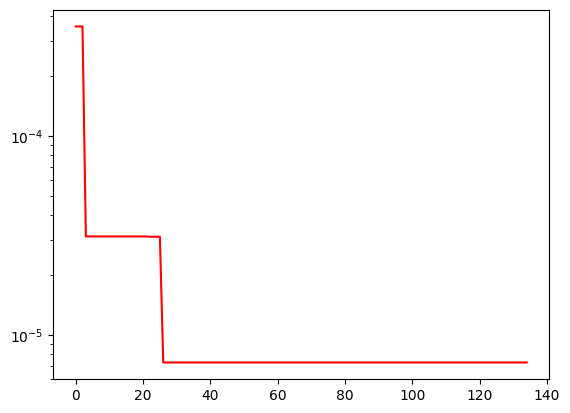

In [11]:
result = run_chain(n_init=10, n_steps=125)
plt.plot(-result/1000, 'r')
plt.yscale("log")

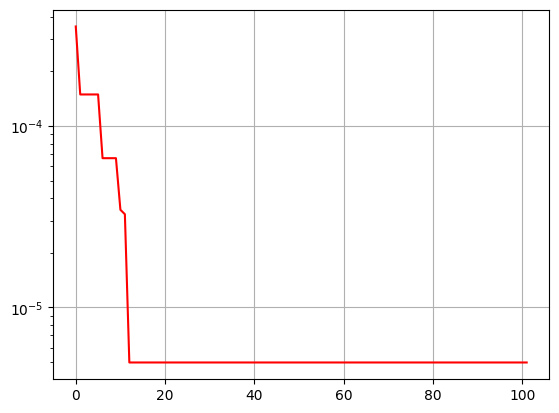

In [32]:
scale = 16.86781883239746
plt.plot(-result/1000, 'r')
plt.yscale("log")
# plt.ylim(0.0000001, 0.001)
plt.grid()

In [12]:
def run_ensemble(n_chains: 25, eval_function = eval_function, n_init: int=3, n_steps: int = 50):
  y1s = []
  for i in range(n_chains):
    print(f"Chain: {i+1} of {n_chains}")
    y1 = run_chain(eval_function = eval_function, n_init=n_init, n_steps = n_steps)
    y1s.append(y1)

  return np.array(y1s)

In [13]:
result = run_ensemble(n_chains=25, eval_function=eval_function, n_init=5, n_steps=100)

Chain: 1 of 25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Chain: 2 of 25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Chain: 3 of 25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
Chain: 4 of 25
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26

In [35]:
result2 = -result/1000
means = np.mean(result2, axis=0)
stds = np.std(result2, axis = 0)
upper, lower = means+2*stds , means-2*stds

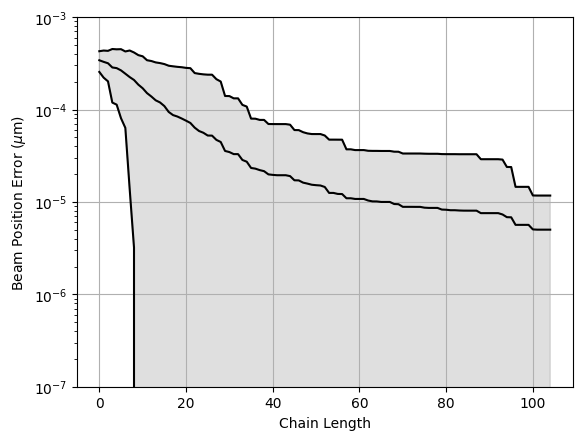

In [36]:
x = np.arange(len(means))
plt.plot(x, means, 'k')
plt.plot(x, lower, 'k')
plt.plot(x, upper, 'k')
# plt.plot(np.exp(-upper*scale2), 'k')
plt.fill_between(x, lower, upper, alpha=0.25, color='gray')
plt.yscale("log")
plt.ylabel("Beam Position Error ($\mu$m)");
plt.xlabel("Chain Length")
plt.ylim(0.0000001, 0.001)
plt.grid()

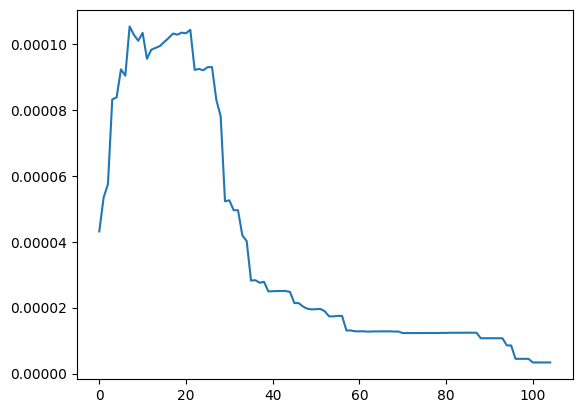

In [26]:
plt.plot(stds)

In [ ]:
low = 0.25
high = 0.75
vocs = VOCS(
variables = {"x1": [low, high],
                 "x2": [low, high],
                 "x3": [low, high],
                 "x4": [low, high],
                 "x5": [low, high],
                 "x6": [low, high],
                 "x7": [low, high],
                 "x8": [low, high]},
    objectives = {"f": "MAXIMIZE"},
)

evaluator = Evaluator(function=eval_function)
generator = ExpectedImprovementGenerator(vocs=vocs)

X = Xopt(evaluator=evaluator, generator=generator, vocs=vocs)
X.random_evaluate(500)

,x1,x2,x3,x4,x5,x6,x7,x8,f,xopt_runtime,xopt_error
0,0.627892,0.320302,0.610577,0.390443,0.607679,0.457378,0.307482,0.739009,0.012401,0.587733,False
1,0.734047,0.729378,0.299860,0.352733,0.519444,0.671499,0.385207,0.633905,0.003407,0.376343,False
2,0.528931,0.332837,0.749632,0.519006,0.735964,0.715099,0.455226,0.355106,0.240397,0.376563,False
3,0.727665,0.422746,0.573278,0.511020,0.746200,0.268584,0.556777,0.514800,0.003618,0.368231,False
4,0.565507,0.471444,0.746155,0.414059,0.292148,0.595617,0.399104,0.593537,0.072304,0.348424,False
...,...,...,...,...,...,...,...,...,...,...,...
495,0.662680,0.263591,0.567285,0.744867,0.393955,0.600352,0.416970,0.749877,0.007353,0.559370,False
496,0.736108,0.417912,0.711155,0.526089,0.654778,0.451549,0.352419,0.680311,0.003347,0.526352,False
497,0.653793,0.385984,0.504813,0.671022,0.715322,0.639670,0.700684,0.363829,0.008307,0.533633,False
498,0.255004,0.296238,0.646064,0.550878,0.645521,0.312811,0.449738,0.587353,0.003129,0.452078,False


In [ ]:
def get_mic(x, y):
  mine = MINE(alpha=0.6, c=15, est="mic_approx")
  mine.compute_score(x, y)
  MIC=mine.mic()
  return MIC

In [ ]:
get_mic(X.generator.data["x1"] ,X.generator.data["f"])

1.0000000000000002

In [ ]:
mics = []
for x in ["x1", "x2", "x3", "x4", "x5", "x6", "x7", "x8"]:
  mic = get_mic(X.generator.data[x], X.generator.data["f"])
  print(x, ": ",mic)
  mics.append(mic)

x1 :  1.0000000000000002
x2 :  0.15107232260000283
x3 :  0.14404500200602954
x4 :  0.16694159345856718
x5 :  0.16296549859056092
x6 :  0.1665536200192665
x7 :  0.17469330179181602
x8 :  0.17319352408543626


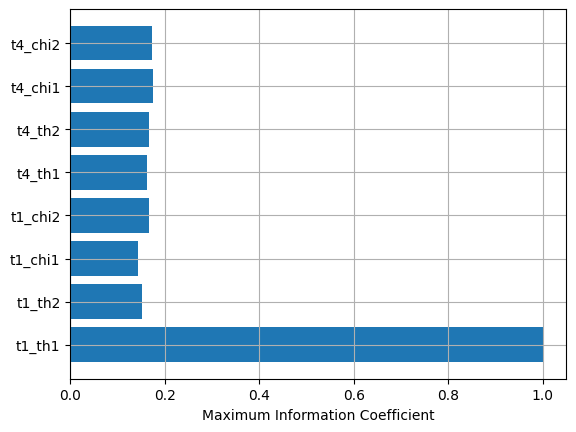

In [ ]:
labels = ["t1_th1", "t1_th2", "t1_chi1", "t1_chi2", "t4_th1", "t4_th2", "t4_chi1", "t4_chi2"]
plt.barh(labels, mics)
plt.grid()
plt.xlabel("Maximum Information Coefficient");

Text(0, 0.5, 't4_th1')

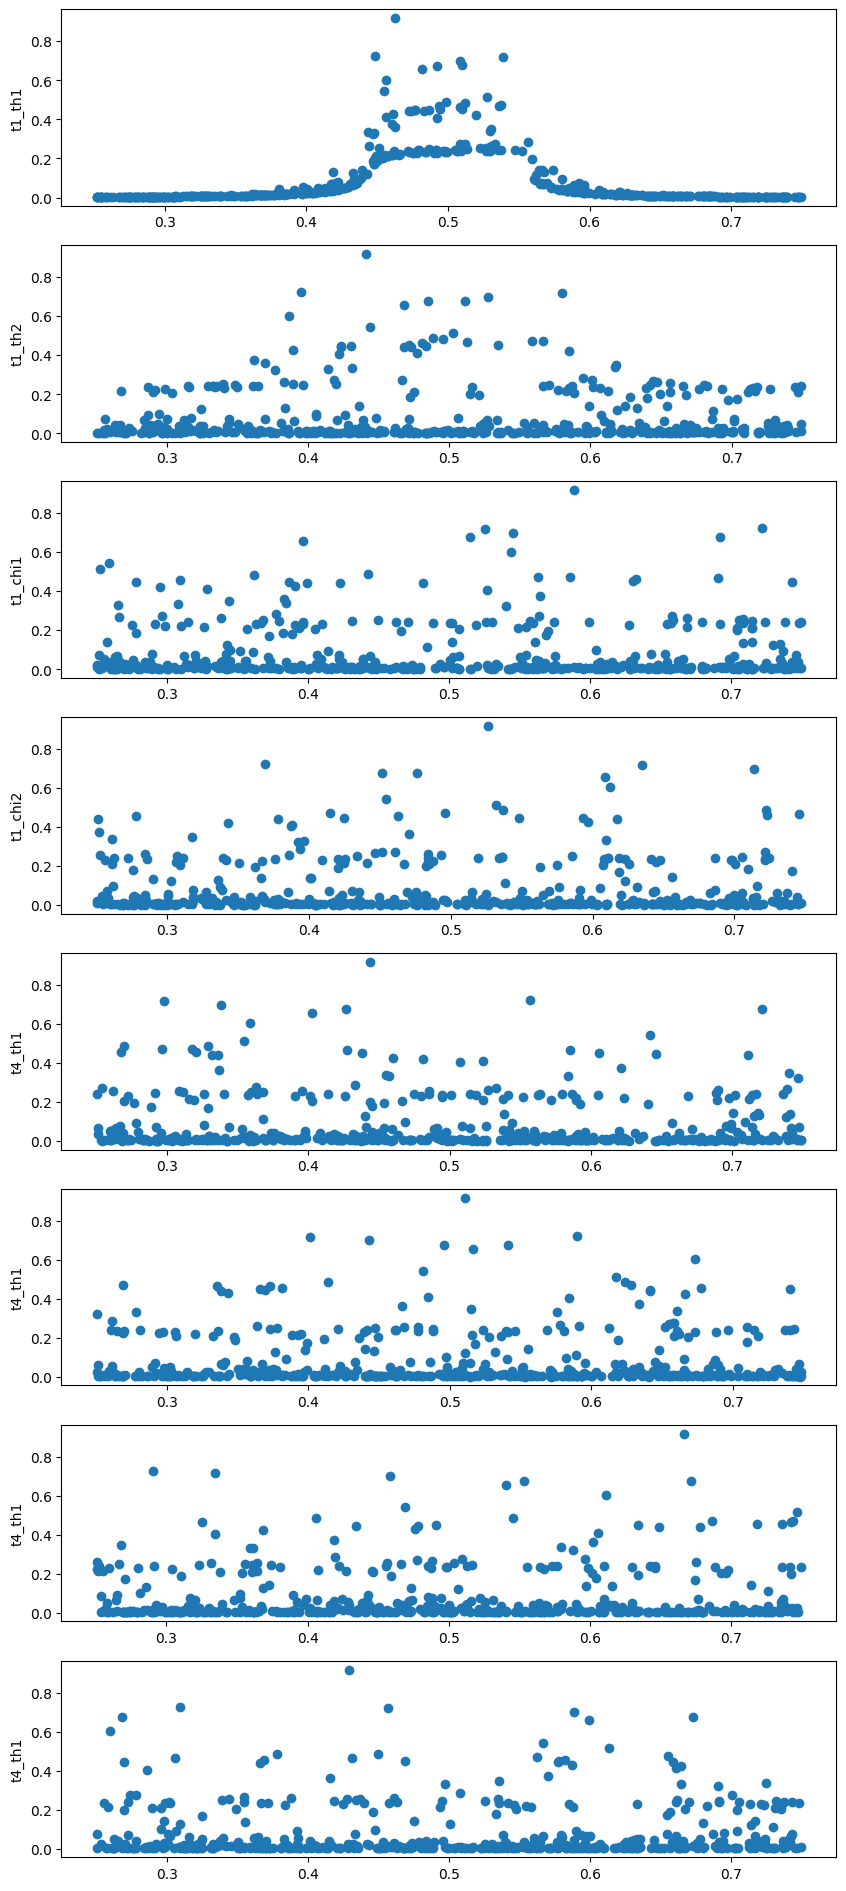

In [ ]:
fix, axs = plt.subplots(nrows=8, figsize=(10, 24))
axs[0].scatter(X.generator.data["x1"], X.generator.data["f"])
axs[0].set_ylabel('t1_th1')

axs[1].scatter(X.generator.data["x2"], X.generator.data["f"])
axs[1].set_ylabel('t1_th2')

axs[2].scatter(X.generator.data["x3"], X.generator.data["f"])
axs[2].set_ylabel('t1_chi1')

axs[3].scatter(X.generator.data["x4"], X.generator.data["f"])
axs[3].set_ylabel('t1_chi2')

axs[4].scatter(X.generator.data["x5"], X.generator.data["f"])
axs[4].set_ylabel('t4_th1')

axs[5].scatter(X.generator.data["x6"], X.generator.data["f"])
axs[5].set_ylabel('t4_th1')

axs[6].scatter(X.generator.data["x7"], X.generator.data["f"])
axs[6].set_ylabel('t4_th1')

axs[7].scatter(X.generator.data["x8"], X.generator.data["f"])
axs[7].set_ylabel('t4_th1')


In [ ]:
low = 0.25
high = 0.75
vocs = VOCS(
    variables = {"x1": [low, high],
                 "x2": [low, high],
                 "x3": [low, high],
                 "x4": [low, high],
                 "x5": [low, high],
                 "x6": [low, high],
                 "x7": [low, high],
                 "x8": [low, high]},
    objectives = {"f1": "MAXIMIZE", "f2": "MAXIMIZE"},
)
vocs

VOCS(variables={'x1': [0.25, 0.75], 'x2': [0.25, 0.75], 'x3': [0.25, 0.75], 'x4': [0.25, 0.75], 'x5': [0.25, 0.75], 'x6': [0.25, 0.75], 'x7': [0.25, 0.75], 'x8': [0.25, 0.75]}, constraints={}, objectives={'f1': 'MAXIMIZE', 'f2': 'MAXIMIZE'}, constants={}, observables=[])

In [ ]:
evaluator = Evaluator(function=eval_function)
evaluator

Evaluator(function=<function eval_function at 0x7df679658a60>, max_workers=1, executor=NormalExecutor[DummyExecutor](loader=ObjLoader[DummyExecutor](object=None, loader=CallableModel(callable=<class 'xopt.evaluator.DummyExecutor'>, signature=Kwargs_DummyExecutor(args=[], kwarg_order=[])), object_type=<class 'xopt.evaluator.DummyExecutor'>), executor_type=<class 'xopt.evaluator.DummyExecutor'>, submit_callable='submit', map_callable='map', shutdown_callable='shutdown', executor=<xopt.evaluator.DummyExecutor object at 0x7df677c7a500>), function_kwargs={}, vectorized=False)

In [ ]:
ref_point = eval_function({"x1": 0.65, "x2": 0.65, "x3": 0.65, "x4": 0.65, "x5": 0.65, "x6": 0.65, "x7": 0.65, "x8": 0.65})
ref_point

{'f1': 0.009041455574333668, 'f2': 0.47309404611587524}

In [ ]:
generator = MOBOGenerator(vocs=vocs, reference_point= ref_point)
generator

MOBOGenerator(supports_batch_generation=False, supports_multi_objective=True, vocs=VOCS(variables={'x1': [0.25, 0.75], 'x2': [0.25, 0.75], 'x3': [0.25, 0.75], 'x4': [0.25, 0.75], 'x5': [0.25, 0.75], 'x6': [0.25, 0.75], 'x7': [0.25, 0.75], 'x8': [0.25, 0.75]}, constraints={}, objectives={'f1': 'MAXIMIZE', 'f2': 'MAXIMIZE'}, constants={}, observables=[]), data=None, model=None, n_monte_carlo_samples=128, turbo_controller=None, use_cuda=False, gp_constructor=StandardModelConstructor(name='standard', use_low_noise_prior=True, covar_modules={}, mean_modules={}, trainable_mean_keys=[], transform_inputs=True, custom_noise_prior=None), numerical_optimizer=LBFGSOptimizer(name='LBFGS', n_restarts=20, max_iter=2000, max_time=None), max_travel_distances=None, fixed_features=None, computation_time=None, log_transform_acquisition_function=False, n_interpolate_points=None, n_candidates=1, reference_point={'f1': 0.009041455574333668, 'f2': 0.47309404611587524})

In [ ]:
generator.n_monte_carlo_samples = 256
generator.numerical_optimizer.n_restarts = 40


X = Xopt(generator=generator, evaluator=evaluator, vocs=vocs)
X.random_evaluate(200)
X.data

,x1,x2,x3,x4,x5,x6,x7,x8,f1,f2,xopt_runtime,xopt_error
0,0.276735,0.722521,0.522487,0.567857,0.542163,0.593578,0.496195,0.293608,0.003767,0.473094,0.696497,False
1,0.260610,0.417171,0.567089,0.328540,0.332493,0.427236,0.332561,0.592003,0.003271,0.473094,0.600088,False
2,0.691364,0.261580,0.551662,0.316136,0.399406,0.521412,0.697555,0.328156,0.005207,0.473094,0.781240,False
3,0.268122,0.590817,0.357882,0.674494,0.506046,0.566869,0.450640,0.730164,0.003427,0.473094,0.631549,False
4,0.565769,0.408793,0.637384,0.737209,0.373025,0.671260,0.506127,0.348722,0.070207,0.498333,0.559013,False
...,...,...,...,...,...,...,...,...,...,...,...,...
195,0.667547,0.338408,0.354578,0.590545,0.494514,0.271575,0.610532,0.662386,0.006727,0.473094,0.332835,False
196,0.630233,0.737933,0.718102,0.488708,0.500000,0.504662,0.323312,0.320758,0.023156,0.509754,0.340422,False
197,0.734323,0.495049,0.507436,0.435774,0.267994,0.362191,0.735644,0.710505,0.003416,0.473094,0.331333,False
198,0.547187,0.401397,0.640101,0.333643,0.260243,0.373144,0.352152,0.451448,0.246729,0.495008,0.330363,False


In [ ]:
for i in range(100):
  print(i)
  X.step()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [ ]:
X.generator.data

,x1,x2,x3,x4,x5,x6,x7,x8,f1,f2,xopt_runtime,xopt_error
0,0.280899,0.618092,0.387023,0.676390,0.721505,0.619388,0.561077,0.258912,0.003843,0.473094,0.605604,False
1,0.403506,0.423805,0.744354,0.675219,0.703456,0.619884,0.466891,0.395147,0.025021,0.491633,0.325034,False
2,0.465592,0.324839,0.750000,0.674756,0.694763,0.620217,0.418410,0.464523,0.234990,0.478840,0.385248,False
3,0.379005,0.264380,0.750000,0.675566,0.715293,0.619437,0.506628,0.387651,0.027855,0.476867,0.316340,False
4,0.477045,0.434754,0.749671,0.674796,0.694662,0.620216,0.411454,0.476296,0.945371,0.512590,0.415459,False
...,...,...,...,...,...,...,...,...,...,...,...,...
97,0.609380,0.577010,0.453188,0.250473,0.263302,0.432865,0.481349,0.397988,0.018088,0.473094,0.312028,False
98,0.685235,0.651930,0.596292,0.692240,0.646119,0.375941,0.253942,0.285114,0.005653,0.485858,0.310415,False
99,0.721477,0.317078,0.427456,0.380799,0.462456,0.363041,0.520948,0.630091,0.003754,0.473094,0.309342,False
100,0.685059,0.391987,0.553286,0.641736,0.308687,0.386867,0.643863,0.323220,0.005597,0.473094,0.308407,False


In [ ]:
y1 = X.generator.data["f1"]
y2 = X.generator.data["f2"]

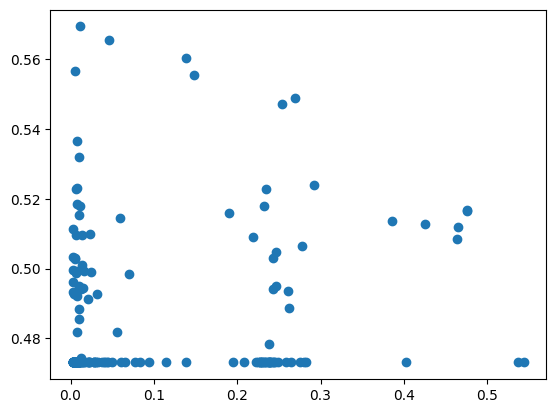

In [ ]:
plt.scatter(y1, y2)

In [ ]:
scale1, scale2 = 62186.2678, 16.801

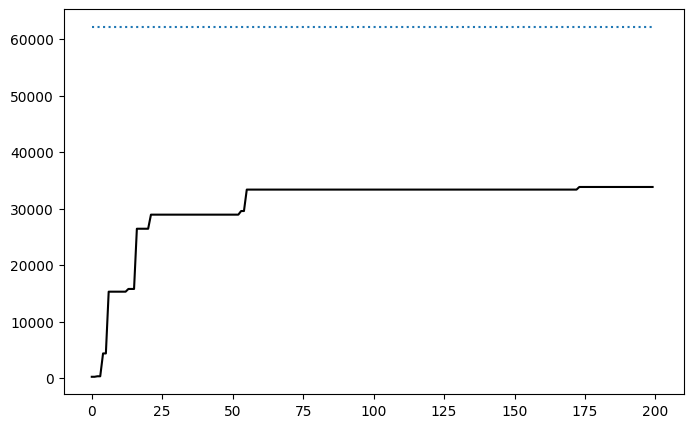

In [ ]:
plt.figure(figsize=(8,5))


y1_maxs = np.maximum.accumulate(y1)
y2_maxs = np.maximum.accumulate(y2)
plt.plot(y1_maxs*scale1, 'k')
plt.hlines(scale1, 0, len(y1_maxs), linestyles="dotted")


plt.show()

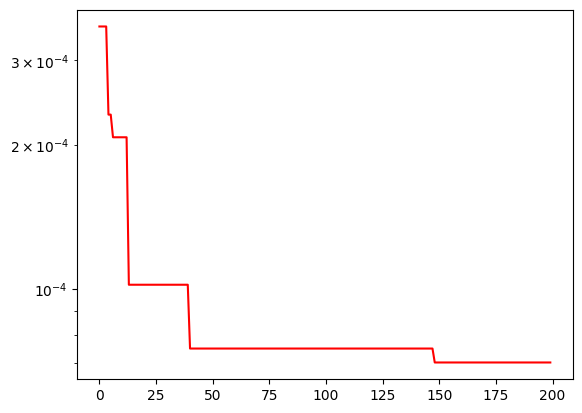

In [ ]:
plt.plot(np.exp(-y2_maxs*scale2), 'r')
plt.yscale("log")

In [ ]:
y2_maxs.shape

(80,)

In [ ]:
temp = np.stack([y1_maxs, y2_maxs])
temp.shape

(2, 80)

In [ ]:
t = [y1_maxs, y2_maxs]
temp = np.array(t)
temp.shape

(2, 80)

In [ ]:
model = generator.train_model()

In [ ]:
model

ModelListGP(
  (models): ModuleList(
    (0-1): 2 x SingleTaskGP(
      (likelihood): GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
      (mean_module): ConstantMean()
      (covar_module): ScaleKernel(
        (base_kernel): MaternKernel(
          (lengthscale_prior): GammaPrior()
          (raw_lengthscale_constraint): Positive()
        )
        (outputscale_prior): GammaPrior()
        (raw_outputscale_constraint): Positive()
      )
      (outcome_transform): Standardize()
      (input_transform): Normalize()
    )
  )
  (likelihood): LikelihoodList(
    (likelihoods): ModuleList(
      (0-1): 2 x GaussianLikelihood(
        (noise_covar): HomoskedasticNoise(
          (noise_prior): GammaPrior()
          (raw_noise_constraint): GreaterThan(1.000E-04)
        )
      )
    )
  )
)